In [32]:
import os, random
from os import path
from numpy.random import seed
import keras
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from distutils.dir_util import copy_tree
import shutil
from PIL import Image
from keras import layers,models
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid
from tensorflow import random as tfrandom
import tensorflow as tf
from keras.callbacks import Callback, CSVLogger
import time
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras import backend as K
import math

import cv2

random.seed(42)

In [2]:
base_path=os.getcwd()

In [3]:
base_path

'c:\\Users\\Utilizador\\Desktop\\2_semestre_DS\\Deep_Learning\\DL_GroupProject\\DeepLearning_Group_Project'

In [4]:
dir_path=(base_path+r"\tumor_data")

In [28]:
# rename the images to 1_xx, 2_xx, 3_xx, by the labels 

for _, letter in enumerate(os.listdir(dir_path)):
    folder_letter = os.path.join(dir_path, letter)
 
    counts=0
    for _, image in enumerate(os.listdir(folder_letter)):
        
        dst=image
    
        if '_' in dst:
            continue
        else:
            dst = str(letter) + "_" + str(counts) + ".png"
            #print(dst)
            src = os.path.join(folder_letter, image)
            dst = os.path.join(folder_letter, dst)
            print(counts)
            os.rename(src, dst)
            
        counts=counts+1
        

In [5]:
# define directories for the train, val and test splits
train_path = os.path.join(dir_path, 'train')
val_path = os.path.join(dir_path, 'validation')
test_path = os.path.join(dir_path, 'test')

In [30]:
def createdir(mydir):
    try:
        os.mkdir(mydir)
    except OSError:
        pass

# create the directories

createdir(train_path)
createdir(val_path)
createdir(test_path)

In [31]:
# create the directories for each label for each train, validation and test folders
count=0
for dir in [train_path, val_path, test_path]:
    count+=1
    for letter in ['1','2','3']:
        if count == 1:
            createdir(os.path.join(dir,str("train_{0}".format(str(letter)))))
        elif count == 2:
            createdir(os.path.join(dir,str("val_{0}".format(str(letter)))))   
        elif count == 3:
            createdir(os.path.join(dir,str("test_{0}".format(str(letter)))))
        

In [32]:
# copy all the images for the train folder to then split them for validation and test folders 

count=0

for dir_ in [train_path+r'\train_1', train_path+r'\train_2', train_path+r'\train_3']:
        if len(os.listdir(dir_)) != 0:
            print('break')
            for f in os.listdir(dir_):
                os.remove(os.path.join(dir_, f))
                
for dir in [dir_path+r"\1", dir_path+r"\2", dir_path+r"\3"]:
    count+=1
    
    if count == 1:
        copy_tree(dir, train_path+r'\train_1')
    elif count==2:
        copy_tree(dir, train_path+r'\train_2')
    elif count==3:
        copy_tree(dir, train_path+r'\train_3')

break
break
break


In [33]:
# proportion we want for train, val_test and the test datasets
prop_train=0.80
prop_val_test=0.20
prop_test=0.50 

In [34]:
labels={'label1':708,'label2':1426,'label3':930}

In [35]:
# input images in VALIDATION

count=0
for index, letter in enumerate(os.listdir(train_path)):
    count+=1
    folder_letter_source = os.path.join(train_path, letter)
    folder_letter_destiny_val = os.path.join(val_path, str("val_{0}".format(str(count))))

    images_val = random.sample(os.listdir(folder_letter_source), k=round(prop_val_test*labels['label{0}'.format(str(count))]))
    count1=0
    
    for image in images_val:
        count1+=1
        if count1==1 and len(os.listdir(folder_letter_destiny_val)) != 0:
            print('break')
            for f in os.listdir(folder_letter_destiny_val):
                os.remove(os.path.join(folder_letter_destiny_val, f))
            
        src = os.path.join(folder_letter_source, image)
        dst = os.path.join(folder_letter_destiny_val, image)
        shutil.move(src, dst)


break
break
break


In [36]:
labels['label1']=round(labels['label1']*prop_val_test)
labels['label2']=round(labels['label2']*prop_val_test)
labels['label3']=round(labels['label3']*prop_val_test)
labels

{'label1': 142, 'label2': 285, 'label3': 186}

In [37]:
# input images in TEST

count=0
for index, letter in enumerate(os.listdir(val_path)):
    count+=1
    folder_letter_source = os.path.join(val_path, letter)
    folder_letter_destiny_test = os.path.join(test_path, str("test_{0}".format(str(count))))

    images_val = random.sample(os.listdir(folder_letter_source), k=round(prop_test*labels['label{0}'.format(str(count))]))
    count1=0
    
    for image in images_val:
        count1+=1
        if count1==1 and len(os.listdir(folder_letter_destiny_test)) != 0:
            print('break')
            for f in os.listdir(folder_letter_destiny_test):
                os.remove(os.path.join(folder_letter_destiny_test, f))
            
        src = os.path.join(folder_letter_source, image)
        dst = os.path.join(folder_letter_destiny_test, image)
        shutil.move(src, dst)
        

break
break
break


In [22]:
train_datagen_aug=ImageDataGenerator(
                    rescale=1./255,
                    #rotation_range=50,
                    rotation_range=10,
                    shear_range=0.05)
                    #horizontal_flip=True )

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
)

Found 2451 images belonging to 3 classes.


In [19]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),  
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150), 
    batch_size=20,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [18]:
train_generator_rgb = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
)

val_generator_rgb = val_datagen.flow_from_directory(
    val_path,
    target_size=(150, 150),  
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
)

test_generator_rgb = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150), 
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.
Found 306 images belonging to 3 classes.


In [9]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [11]:
def save_times(model, times,name_model):
  
    times_dict = {'Model': ['Model {}'.format(str(name_model))]}
    for idx, time in enumerate(times):
        times_dict[idx] = times[idx]
    df_save_times = pd.DataFrame(times_dict)

    if os.path.exists(r'.\models\models_times.csv'):
        df_save_times.to_csv(r'.\models\models_times.csv', mode='a', header=False, index=False)
    else:
        df_save_times.to_csv(r'.\models\models_times.csv')

In [12]:
def plot_history(his):
    f1 = his['f1_m']
    f1_val=his['val_f1_m']
    loss = his['loss']
    loss_val=his['val_loss']

    epochs=range(1,len(f1)+1)

    plt.plot(epochs, f1,'bo',label='Training F1')
    plt.plot(epochs, f1_val,'b',label='Validation F1')
    plt.title('Training and Validation F1 score')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss,'bo',label='Training loss')
    plt.plot(epochs, loss_val,'b',label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.figure()

In [13]:
def callback(filename):
  callname_list=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
            keras.callbacks.ModelCheckpoint(filepath=os.path.join(base_path+ "\models")+filename, monitor='val_loss',mode='min',verbose=1, save_best_only=True)
            ,time_callback]

  return callname_list

In [26]:
BATCH_SIZE=20 
TRAINING_SIZE = 2451 
VALIDATION_SIZE = 307 

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE)) 
steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE) 
val_steps = compute_steps_per_epoch(VALIDATION_SIZE) 

print(steps_per_epoch)
print(val_steps)

123
16


In [14]:
dependencies = {
    'f1_m': f1_m
}

In [17]:
callbacks_BW = callback("\modelBW.h5")

In [67]:
# model = models.Sequential()

# model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)))
# model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D(2, 2))
# model.add(layers.Flatten())
# model.add(layers.Dense(50, activation='relu'))
# model.add(layers.Dense(3, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_m])

# history_1st = model.fit_generator(train_generator, callbacks=callbacks_BW, epochs=15, steps_per_epoch=123, validation_steps=16,
#                                  validation_data=val_generator, workers=2)

C:\Users\filip\AppData\Local\Temp/ipykernel_7176/1271958522.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_1st = model.fit_generator(train_generator, callbacks=callbacks_BW, epochs=15, steps_per_epoch=123, validation_steps=16,


Epoch 1/15
123/123 [==============================] - ETA: 0s - loss: 0.7644 - f1_m: 0.5825
Epoch 1: val_loss improved from inf to 0.67267, saving model to c:\Users\filip\OneDrive\Filipa\Faculdade\Mestrado\Deep Learning\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 55s 440ms/step - loss: 0.7644 - f1_m: 0.5825 - val_loss: 0.6727 - val_f1_m: 0.6344
Epoch 2/15
123/123 [==============================] - ETA: 0s - loss: 0.5749 - f1_m: 0.7402
Epoch 2: val_loss improved from 0.67267 to 0.52763, saving model to c:\Users\filip\OneDrive\Filipa\Faculdade\Mestrado\Deep Learning\DeepLearning_Group_Project\models\modelBW.h5
123/123 [==============================] - 64s 514ms/step - loss: 0.5749 - f1_m: 0.7402 - val_loss: 0.5276 - val_f1_m: 0.7422
Epoch 3/15
123/123 [==============================] - ETA: 0s - loss: 0.4463 - f1_m: 0.8097
Epoch 3: val_loss improved from 0.52763 to 0.44213, saving model to c:\Users\filip\OneDrive\Filipa\Faculdade\Mestrado\Deep

In [20]:
modelBW = keras.models.load_model('models/modelBW.h5', custom_objects=dependencies)
historyBW=np.load('models/historyBW.npy',allow_pickle='TRUE').item()
#timesBW = time_callback.times
#save_times(modelBW, timesBW,'modelBW')

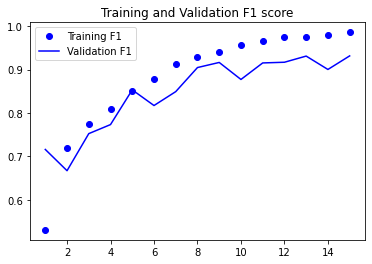

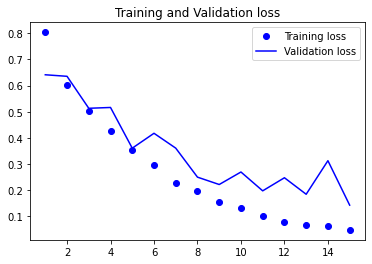

<Figure size 432x288 with 0 Axes>

In [21]:
plot_history(historyBW)

In [14]:
callbacks_BW_inc = callback("\modelBW_inc.h5")
#increase the nr of filters through the CNN

In [17]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Flatten())
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_m])

history_2 = model2.fit_generator(train_generator, callbacks=callbacks_BW_inc, epochs=20, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/20
123/123 [==============================] - ETA: 0s - loss: 0.7884 - f1_m: 0.5414
Epoch 00001: val_loss improved from inf to 0.70448, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_inc.h5
123/123 [==============================] - 71s 581ms/step - loss: 0.7884 - f1_m: 0.5414 - val_loss: 0.7045 - val_f1_m: 0.6552
Epoch 2/20
123/123 [==============================] - ETA: 0s - loss: 0.5886 - f1_m: 0.7374
Epoch 00002: val_loss did not improve from 0.70448
123/123 [==============================] - 66s 539ms/step - loss: 0.5886 - f1_m: 0.7374 - val_loss: 0.7897 - val_f1_m: 0.5382
Epoch 3/20
123/123 [==============================] - ETA: 0s - loss: 0.4686 - f1_m: 0.7887
Epoch 00003: val_loss improved from 0.70448 to 0.59266, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_inc.h5
123/123 [==============================

In [22]:
#np.save('models/historyBW_inc.npy',history_2.history)
modelBW_inc = keras.models.load_model('models/modelBW_inc.h5', custom_objects=dependencies)
historyBW_inc=np.load('models/historyBW_inc.npy',allow_pickle='TRUE').item()
#timesBW = time_callback.times
#save_times(modelBW_inc, timesBW,'modelBW_inc')

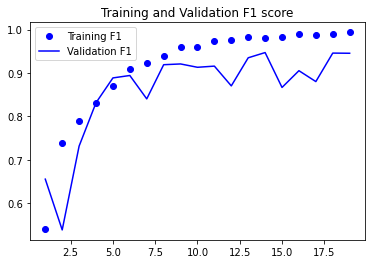

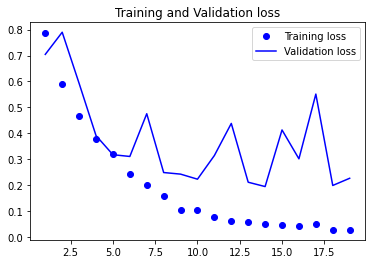

<Figure size 432x288 with 0 Axes>

In [23]:
plot_history(historyBW_inc)

# REDUCING THE NUMBER OF LAYERS

In [27]:
callbacks_BW_simple = callback("\modelBW_simple.h5")
#increase the nr of filters through the CNN

In [29]:
model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Flatten())
model3.add(layers.Dense(50, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_m])

history_3 = model3.fit_generator(train_generator, callbacks=callbacks_BW_simple, epochs=20, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
123/123 [==============================] - ETA: 0s - loss: 0.7678 - f1_m: 0.5578
Epoch 00001: val_loss improved from inf to 0.61245, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_simple.h5
123/123 [==============================] - 113s 921ms/step - loss: 0.7678 - f1_m: 0.5578 - val_loss: 0.6124 - val_f1_m: 0.7070
Epoch 2/20
123/123 [==============================] - ETA: 0s - loss: 0.5192 - f1_m: 0.7714
Epoch 00002: val_loss improved from 0.61245 to 0.54263, saving model to c:\Users\Utilizador\Desktop\2_semestre_DS\Deep_Learning\DL_GroupProject\DeepLearning_Group_Project\models\modelBW_simple.h5
123/123 [==============================] - 94s 766ms/step - loss: 0.5192 - f1_m: 0.7714 - val_loss: 0.5426 - val_f1_m: 0.7539
Epoch 3/20
123/123 [==============================] - ETA: 0s - loss: 0.3763 - f1_m: 0.8434
Epoch 0

In [30]:
np.save('models/historyBW_simple.npy',history_3.history)
modelBW_simple = keras.models.load_model('models/modelBW_simple.h5', custom_objects=dependencies)
historyBW_simple=np.load('models/historyBW_simple.npy',allow_pickle='TRUE').item()
timesBW_simple = time_callback.times
save_times(modelBW_simple, timesBW_simple,'modelBW_simple')

# DATA AUGMENTATION AND DROP OUT

In [20]:
callbacks_BW_aug = callback("\modelBW_aug.h5")
#increase the nr of filters through the CNN

In [23]:
model4 = models.Sequential()

model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(50, activation='relu'))
model4.add(layers.Dense(3, activation='softmax'))

model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[f1_m])

history_4 = model4.fit_generator(train_generator_aug, callbacks=callbacks_BW_aug, epochs=30, steps_per_epoch=123, validation_steps=16,
                                 validation_data=val_generator, workers=2)

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 0.7956 - f1_m: 0.5555
Epoch 00001: val_loss did not improve from 0.36242
123/123 [==============================] - 104s 844ms/step - loss: 0.7956 - f1_m: 0.5555 - val_loss: 0.8542 - val_f1_m: 0.6359
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 0.6057 - f1_m: 0.7133
Epoch 00002: val_loss did not improve from 0.36242
123/123 [==============================] - 78s 631ms/step - loss: 0.6057 - f1_m: 0.7133 - val_loss: 0.8034 - val_f1_m: 0.6151
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 0.4965 - f1_m: 0.7806
Epoch 00003: val_loss did not improve from 0.36242
123/123 [==============================] - 107s 874ms/step - loss: 0.4965 - f1_m: 0.7806 - val_loss: 0.5510 - val_f1_m: 0.7851
Epoch 4/30
123/123 [==============================] - ETA: 0s - loss: 0.4442 - f1_m: 0.8098
Epoch 00004: val_loss did not improve from 0.36242
123/123 [==============================] - 82s 6

In [24]:
np.save('models/historyBW_aug.npy',history_4.history)
modelBW_aug = keras.models.load_model('models/modelBW_aug.h5', custom_objects=dependencies)
historyBW_aug=np.load('models/historyBW_aug.npy',allow_pickle='TRUE').item()
timesBW_aug = time_callback.times
save_times(modelBW_aug, timesBW_aug,'modelBW_aug')

# UNET

In [93]:
def double_conv_block(x, n_filters):
       # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, (3,3), padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
       # upsample
    x = layers.Conv2DTranspose(n_filters,(3,3), 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

In [94]:
 def build_unet_model():
 # inputs
  inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
  f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
  f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
  f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
  f4, p4 = downsample_block(p3, 512)
  # 5 - bottleneck
  bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
  u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
  u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
  u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
  u9 = upsample_block(u8, f1, 64)
   # outputs
  outputs = layers.Conv2D(3, (1,1), padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
  return unet_model

In [95]:
unet_model = build_unet_model()

In [96]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=[f1_m])

In [74]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(128, 128),
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(128, 128),  
    batch_size=20,
    class_mode='categorical',
    color_mode='rgb',
)

Found 2451 images belonging to 3 classes.
Found 307 images belonging to 3 classes.


In [97]:

model_history = unet_model.fit(train_generator,
                              epochs=15,
                              steps_per_epoch=123,
                              validation_steps=16,
                              validation_data=val_generator)

Epoch 1/15


InvalidArgumentError:  Incompatible shapes: [20,3] vs. [20,128,128,3]
	 [[node mul_1 (defined at \UTILIZ~1\AppData\Local\Temp/ipykernel_23064/1853306922.py:8) ]] [Op:__inference_train_function_49228]

Errors may have originated from an input operation.
Input Source operations connected to node mul_1:
 IteratorGetNext (defined at \UTILIZ~1\AppData\Local\Temp/ipykernel_23064/1190296805.py:1)

Function call stack:
train_function


In [73]:
preds = modelBW.predict(test_generator)
predicted_class_indices = np.argmax(preds, axis=1)
test_labels = test_generator.labels

cm = confusion_matrix(test_labels, predicted_class_indices)
test_score = modelBW.evaluate_generator(test_generator)

C:\Users\filip\AppData\Local\Temp/ipykernel_7176/1856620179.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_score = modelBW.evaluate_generator(test_generator)


In [74]:
print(classification_report(test_generator.labels, predicted_class_indices))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88        71
           1       0.92      0.97      0.95       142
           2       0.97      0.97      0.97        93

    accuracy                           0.94       306
   macro avg       0.94      0.92      0.93       306
weighted avg       0.94      0.94      0.94       306



In [ ]:
#modelBW.summary()

In [ ]:
# test_score_modelBW = modelBW.evaluate_generator(test_generator)
# test_score_modelBW

In [ ]:
# Modelo sem aug BW
#  ---- dropout augmentation

# Modelo sem aug RGB
#  ---- dropout augmentation

# funçoes dos plots

# time function comparison